In [1]:
%load_ext autoreload

SimRate
-------

SimRate simulates distributed workflows over a high latency network. 

It simuates:

    . a high-latency network.
    . network congestion
    . approximate TCP behavior, currently Reno/Cubic/HTCP(in progress)
    . distributed workflows. Currently only gridFTP is modeled.
  
The goal is to provide a fast simulator that allows to study how distributed workflow, large or small, long or short, compete over shared network resources. While SimRate needs to model a somewhat realistic TCP behavior, it is not intended to be used to study network protocols, allowing a faster simulation. Additionally, SimRate is not tested and may not support latencies less than 1 millisecond.
 
In order to be fast, SimRate does not model packets moving along a topology. Instead, SimRate models a data flow going through the network as its data rate. A flow data rate is not constant in times. It can change due to the following reasons:

    . congestion is detected on the path. The rate may decreases accordingly to the TCP model.
    . the path has been clean of any congestion, the rate may increase accordingly to the TCP model.
    . the workflow itself is dynamically paced at a given rate.
 
When the rate of a workflow changes, the event is progated through the network like a packet would, simulating routing and latencies. 

Another optimization is to detect congestion per flow as TCP would: it takes a round trip between the sender and the receiver to detected weither there has been packet losses or re-ordering. In other words, SimRate simulates the workflow behavior, based on their RTT, assuming that the data rate remains the same within a RTT period.

SimRate model makes the simulation very simple and fast. However, this comes at the cost of fairly inaccurate TCP behavior, especially in the contect of very short and very low latency flows.


SimRate is implemented in python, based on a discrete event simulation package SimPy. 

Try it out
----------
First, we need a network. The network is made of routers and links, forming its topology:

In [1]:
from simrate import Topology

topo = Topology("test topology", ticks_per_sec=1000)

The new topology object creates the SimRate environment and builds and empty graph. 

The option, ticks_per_sec, defines how much of real time is simulated per SimRate's clock tick. In this exemple, 100 ticks per second means that each simulator tick represents 1 ms of real time. Higher number means a better precision but may come at a high processing time. 

We can now start creating a simple topology of two routers, interconnected with a 100Gbps link and at a latency of 100ms. Note that the parameter is latency and not RTT.

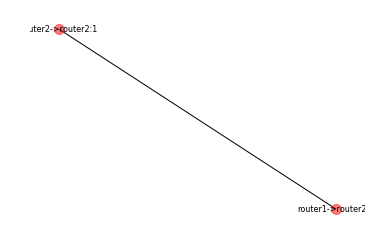

In [2]:
topo.add_link(router_a='router1',router_b='router2',capacity=10000,latency=100) 

topo.draw()

The next step is to create a source and destination of data through the topology. The following will create two servers, each connected to the opposite routers with a 10Gbs link. In this exemple, each of the servers will have a maximum data rate of 8Gbps. In SimRate, a server, or endpoint, is modeled as a router that terminates a path.

Note that the displayed topology represents ports connected by links. This means that routers will be displayed as a set of interconnected ports with links of zero latency. This would need improvement.

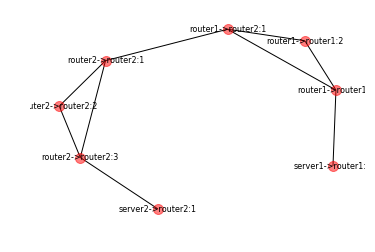

In [9]:
from simrate import Endpoint

server1 = Endpoint(name='server1',topology=topo,capacity=10000,rate=8000)
server1.connect('router1')
server2 = Endpoint(name='server2',topology=topo,capacity=10000,rate=8000)
server2.connect('router2')

topo.draw()

We can now create a workflow. Different kind of workflows may be implemented. Currently, the only workflow implementation models a gridFTP file transfer.

A default implementation is provided by sim.DataTransfer simulating a file transfer between two endpoints. It simulates the following features:
    - dynamic pacing,
    - path computation,
    - routing,
    - multi-stream.
    
The following creates a file transfer workflow. Source, destination, data size. The maximum flow rate is also provided. Other options include the number of parallel streams. Some of options are set directly onto the object. Note than the workflow object is created but not schedule yet. In other words, it is not yet active.

In [14]:
from simrate import DataTransfer

flow1 = DataTransfer(name="flow1",
                     src=server1,
                     dst=server2,
                     data_size=1000000,
                     max_rate=8000,
                     topology=topo)

flow1.info = True
flow1.debug = False
flow1.record_receive = True
                     

The  workflow is scheduled by calling the topology's SimRate environment. An optional starting time can be specified.

Obviously, the API should be simplified. 

In [15]:
topo.schedule_workflow(workflow=flow1)

Once all the workflows are created and scheduled, the simulation can start. It will automatically stop when all workflows have completed.

In [16]:
topo.start_simulation()

Simulation starts 135300.0
135300.0 start file transfer flow1
time: 135.2 secs flow1 rtt: 200 average 7396.44970414
Simulation stopped simulated elapse time: 135.3 real time: 0.0175700187683 real/simulate: 7700.61784134


The output means:
    . flow1 had an RTT of 200ms and went at an average if 7.3 Gbps for a duration of 135 seconds.
    . the overall simulation ran at a rate of 7700. This means that in one real time seconds, the simulated processed 7700 simulated seconds. This is really fast, but this was a single flow, without congestion.

The various outputs depends on the level of debug and traces. 


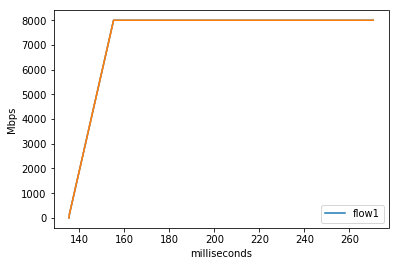

In [17]:
flow1.plot_receive()
topo.show_plots()

Congestion with large RTT
------------------------

In this exemple, we will add a third server, server3, connected to the same router than server2. Two flows will be created, from server1 to server2 and from server3 to server2, creating a congestion point on the router port connected to server2. The first flow, flow1, is going through a much longer path and therefore has a much higher RTT.

In [17]:
%aimport simrate
%autoreload 1
from simrate import Topology

import numpy as np

def init_congestion_model_reno(flow):
    flow.last_stable_rate = 0
    flow.stable_rates = []
    flow.increase_increment = 0

def increase(flow):
    now = flow.topology.now()
    if not flow.congested and flow.current_rate == flow.receive_rate:
        flow.last_stable_rate = flow.current_rate
        flow.stable_rates.append([float(now)/1000,flow.last_stable_rate])
    flow.increase_increment += 1
    flow.last_stable_rate = flow.current_rate
    rate = min (flow.current_rate + np.log(flow.increase_increment) * flow.increase_step, flow.max_rate)
    #rate = min (flow.current_rate + 
    if rate != flow.current_rate:
        flow.current_rate = rate
        return True
    return False

def decrease_reno(flow):
    flow.increase_increment = 0
    rate = max (int(flow.current_rate / 2), flow.increase_step)
    if rate != flow.current_rate:
        flow.current_rate = rate
        return True
    return False
    
def init_congestion_model_cubic(flow):
    flow.last_congestion = flow.topology.now()
    flow.rmax = 0
    flow.current_rate = flow.max_rate * 0.1
    flow.congestion_start = False
    
# rate_increase = (0.4* (time_since_last_congestion - (Rmax * RTT)**(1./3))**3 + Rmax * RTT) / RTT                
def increase_cubic(flow):
    flow.congestion_start = False
    now = float(flow.topology.now()) / 1000
    t = now - flow.last_congestion
    rate_increase = abs(0.4 * (t - (flow.rmax*flow.rtt)**(1./3))**3 + flow.rmax * flow.rtt)
    new_rate = min (flow.current_rate + rate_increase, flow.max_rate)
    if flow.current_rate != new_rate:
        flow.current_rate = new_rate
    flow.rmax = max(flow.rmax,flow.current_rate)

def decrease_cubic(flow):
    now = float(flow.topology.now()) / 1000
    #print flow.name,"decrease",flow.current_rate
    flow.last_congestion = now
    decrease_rate = 0.95
    if not flow.congestion_start:
        decrease_rate = 0.5
        flow.congestion_start = True
    flow.current_rate = max(flow.current_rate * decrease_rate, flow.max_rate * 0.05)
    
def init_congestion_model_htcp(flow):
    flow.last_congestion = flow.topology.now()
    flow.rmax = 15
    
def increase_htcp(flow):
    now = float(flow.topology.now()) / 1000
    new_rate = 0
    t = now - flow.last_congestion
    new_rate = min((t**3) * flow.current_rate / 100 , flow.max_rate) 
    if flow.current_rate != new_rate:
        flow.current_rate = new_rate
        return True
    return False

def decrease_htcp(flow):
    now = float(flow.topology.now()) / 1000
    flow.last_congestion = now
    flow.rmax = flow.current_rate
    flow.current_rate = flow.current_rate * 0.5
    return True
                
topo = Topology("test topology", ticks_per_sec=1000)

from simrate import Endpoint

topo.add_routers(['router1','router2'])
topo.add_link(router_a='router1',router_b='router2',capacity=10000,latency=44)

server1 = Endpoint(name='server1',topology=topo,capacity=10000,rate=10000)
server1.connect('router1', latency=1)
server2 = Endpoint(name='server2',topology=topo,capacity=10000,rate=10000)
server2.connect('router2', latency=1)
server3 = Endpoint(name='server3',topology=topo,capacity=10000,rate=10000)
server3.connect('router2', latency=1)

from simrate import DataTransfer

flow1 = DataTransfer(name="flow1",
                     src=server1,
                     dst=server2,
                     data_size=2000000,
                     max_rate=10000,
                     topology=topo,
                     increase=increase_cubic,
                     decrease=decrease_cubic)

flow1.info = True
flow1.debug = False
flow1.record_receive = True
flow1.record_drop = False
init_congestion_model_cubic(flow1)
flow1.congestion_loss = 1
flow1.record_congestion = True
flow1.congestion_rate_loss = 20

topo.schedule_workflow(workflow=flow1)

flow2 = DataTransfer(name="flow2",
                     src=server3,
                     dst=server2,
                     data_size=2000000,
                     max_rate=10000,
                     topology=topo,
                     increase=increase_cubic,
                     decrease=decrease_cubic)

flow2.info = True
flow2.debug = False
flow2.record_receive = True
flow2.record_drop = False
init_congestion_model_cubic(flow2)
flow2.record_congestion = True
flow2.congestion_rate_loss = 20

topo.schedule_workflow(workflow=flow2)
topo.start_simulation()


Simulation starts 0.0
0.0 start file transfer flow1
0.0 start file transfer flow2
time: 420.624 secs flow1 rtt: 92 average 4754.84042756
time: 502.148 secs flow2 rtt: 4 average 3982.88950668
Simulation stopped simulated elapse time: 502.15 real time: 7.97945904732 real/simulate: 62.9303311192


This times, the simlation takes more processing but it is still reasonable.

Every change of rate was recorded, in memory. The following shows how to visualize the flows.

Note that flow1 , high latency, is quite impacted by the lower latency flow. Of course, after the flow1 is done, flow2 can ramp up to its max rate.

flow1


<IPython.core.display.Javascript object>


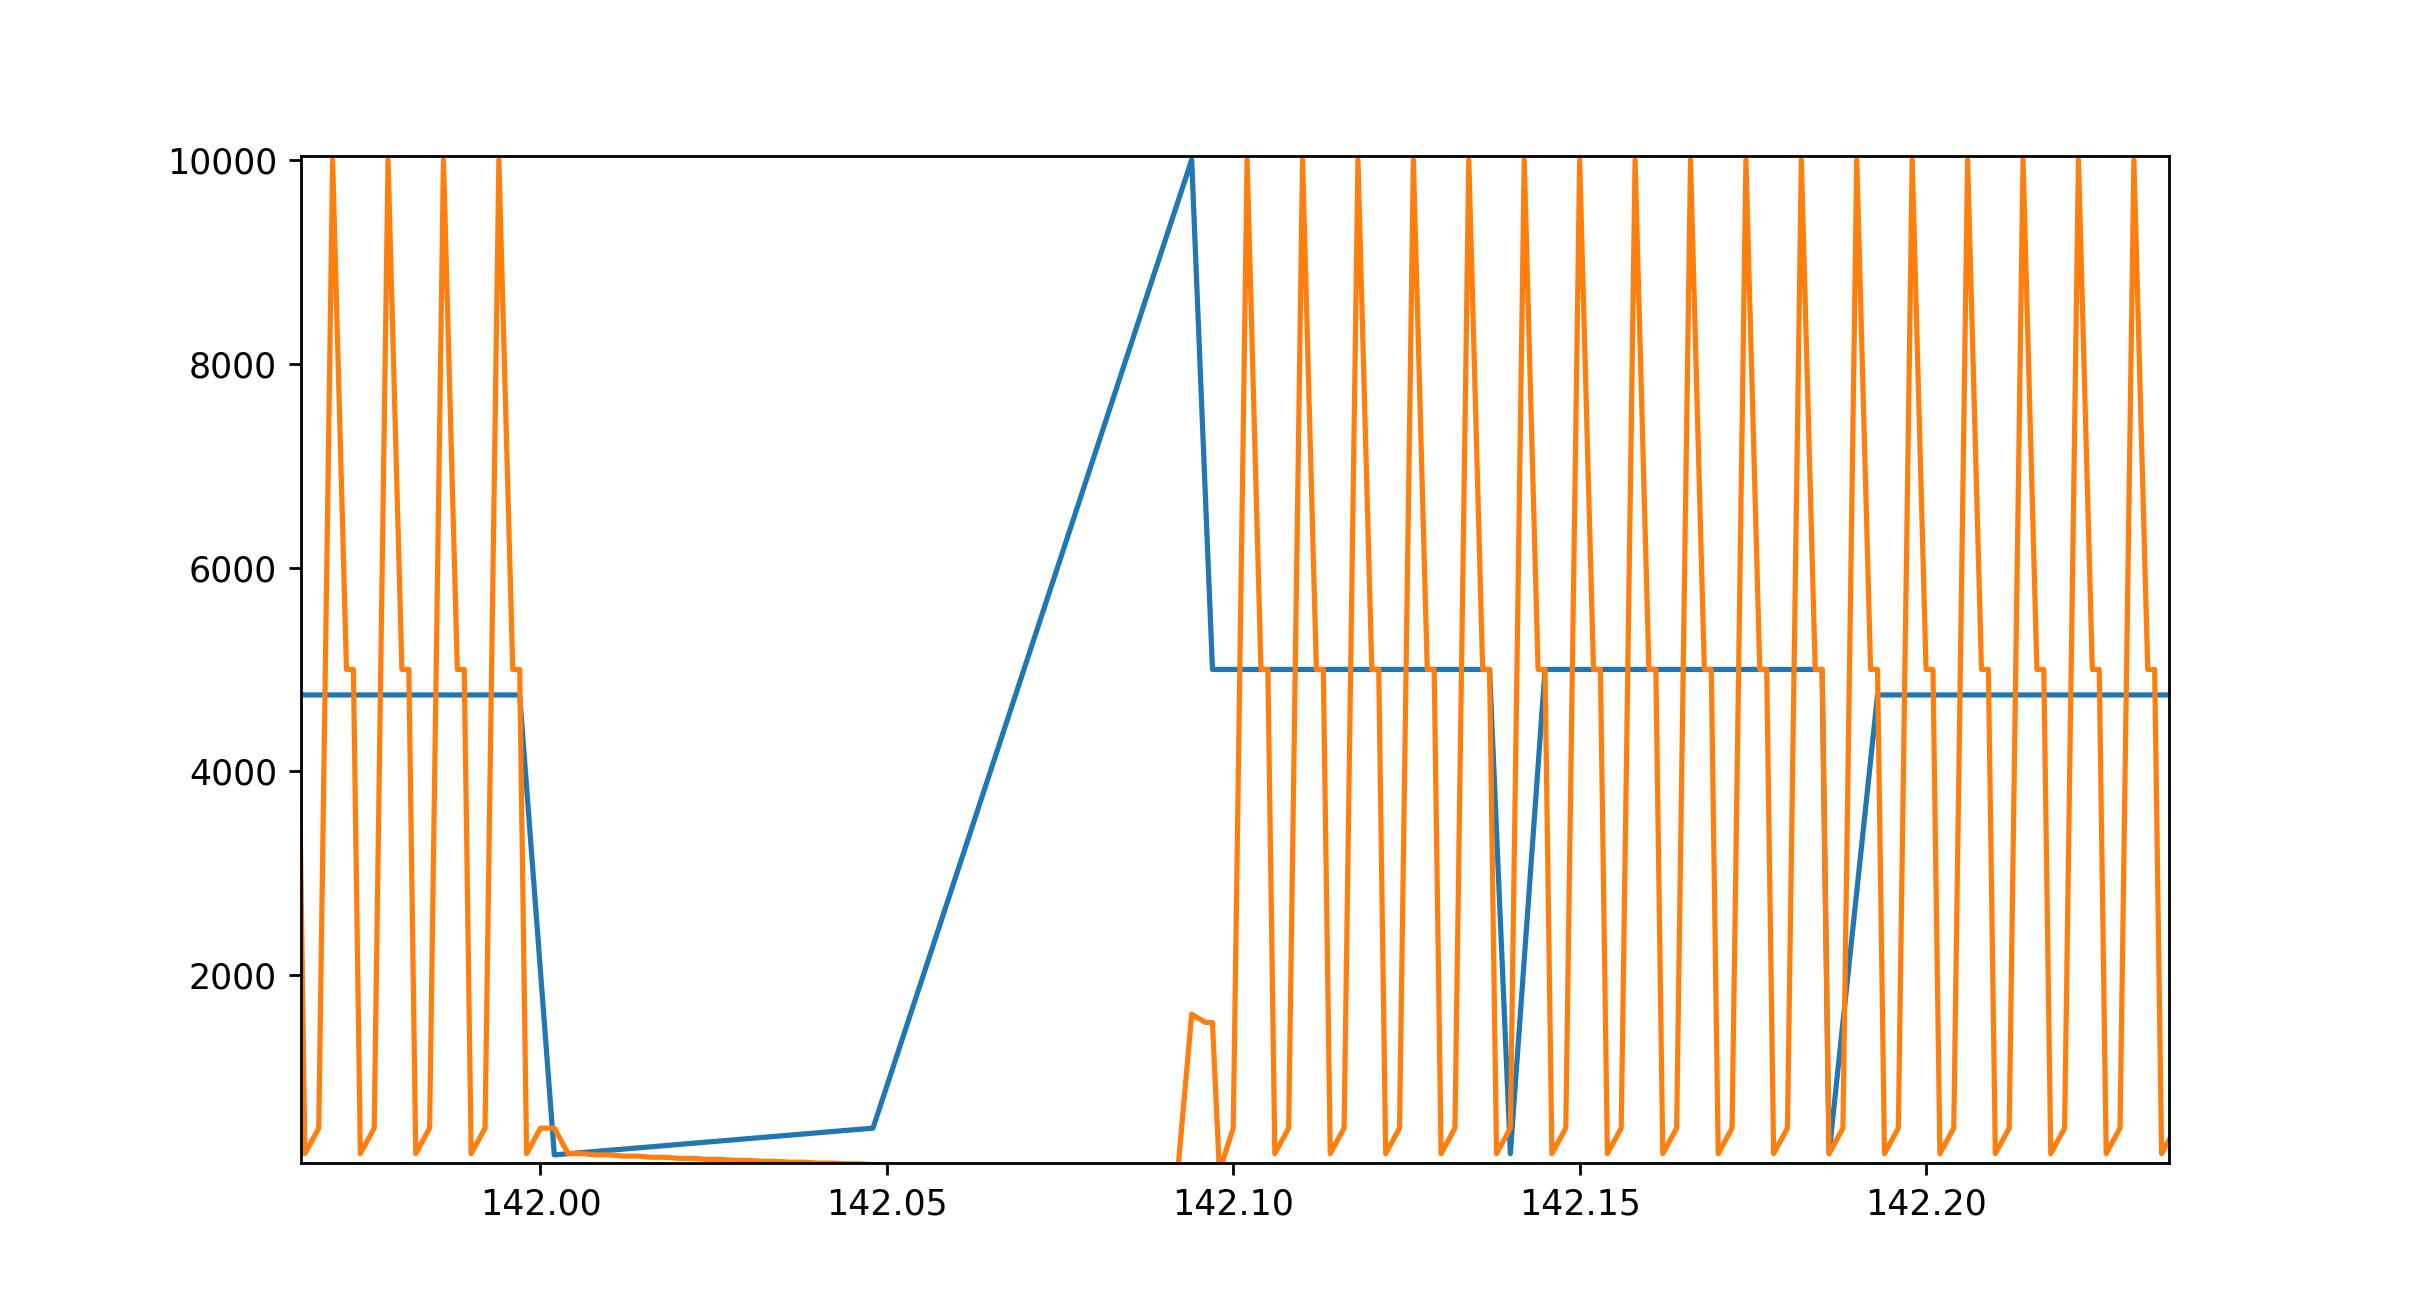

In [23]:
# needs  $ conda install -c conda-forge bqplot
%gui osx
%matplotlib notebook
import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt

import bqplot.pyplot as bplt
from bqplot import LinearScale
from bqplot import Axis

def plot_rate(flow,start=0,stop=-1):
    x,y = zip(*flow.receive_data)
    plot = plt.plot(x,y,label=flow.name)
    return plot

def plot_congestion(flow,start=0,stop=-1):
    x,y = zip(*flow.congestion_data)
    plot = plt.plot(x,y,label=flow.name)
    return plot

print flow1.name
plot1 = plot_rate(flow1)
plot2 = plot_rate(flow2)
plt.show()
#plot = plot_congestion(flow1)
#plt.show()




Flow data can be directly used from python. The following shows the flow2's initial ramp up. Each entry in the flow2.receive_data is two values, simulated time (in second) and rate in Mbps.